# Coding project - Tumor segmentation

The image below is a slice of a brain MRI with a large tumor in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

(218, 180, 3) uint8


<IPython.core.display.Javascript object>


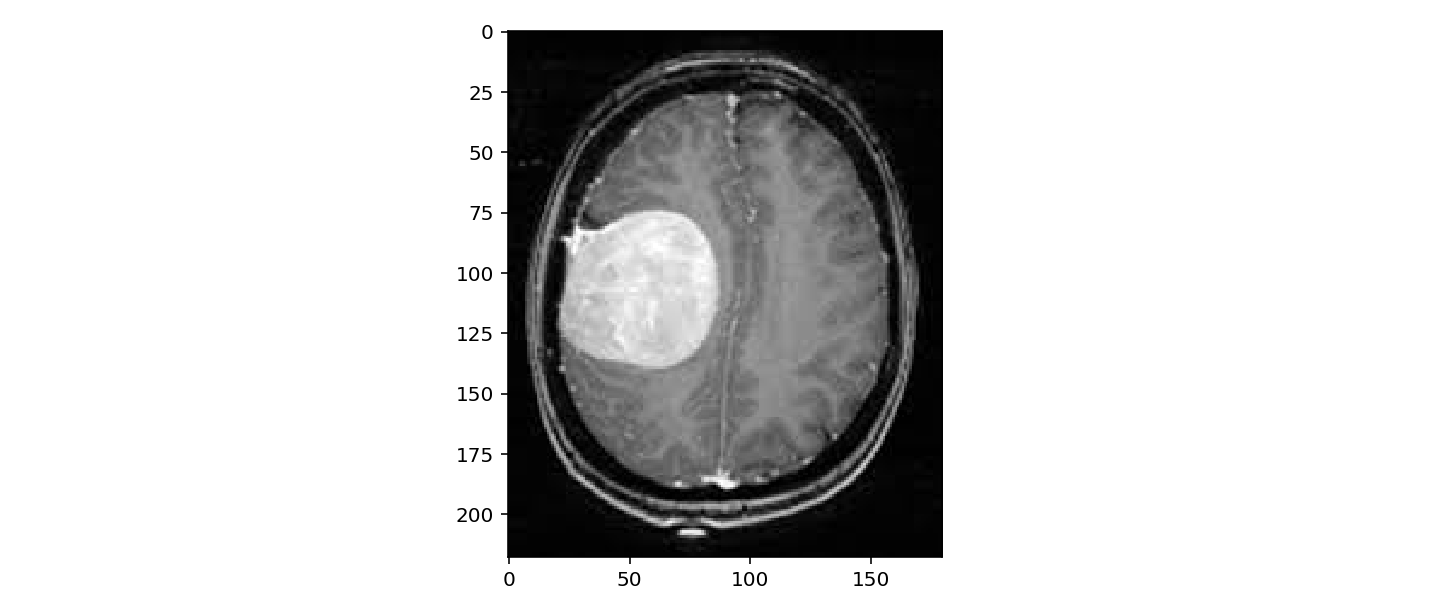

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from skimage.io import imread,imshow
%matplotlib notebook

im = imread('mri_brain.jpg')
print (im.shape,im.dtype)


plt.figure()
imshow(im)
plt.show()

To segment the tumor, the watershed transform is used. The basic idea is to find some markers on the image that will start a region in the purpose of perfoming some region growing. In this implementation, we first blur the image and use some filters in order to dectect main boders. So that a region can grow until it reaches a border.

<ipython-input-153-05f070360673>:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  im_ = gaussian(im, sigma=4)


<IPython.core.display.Javascript object>


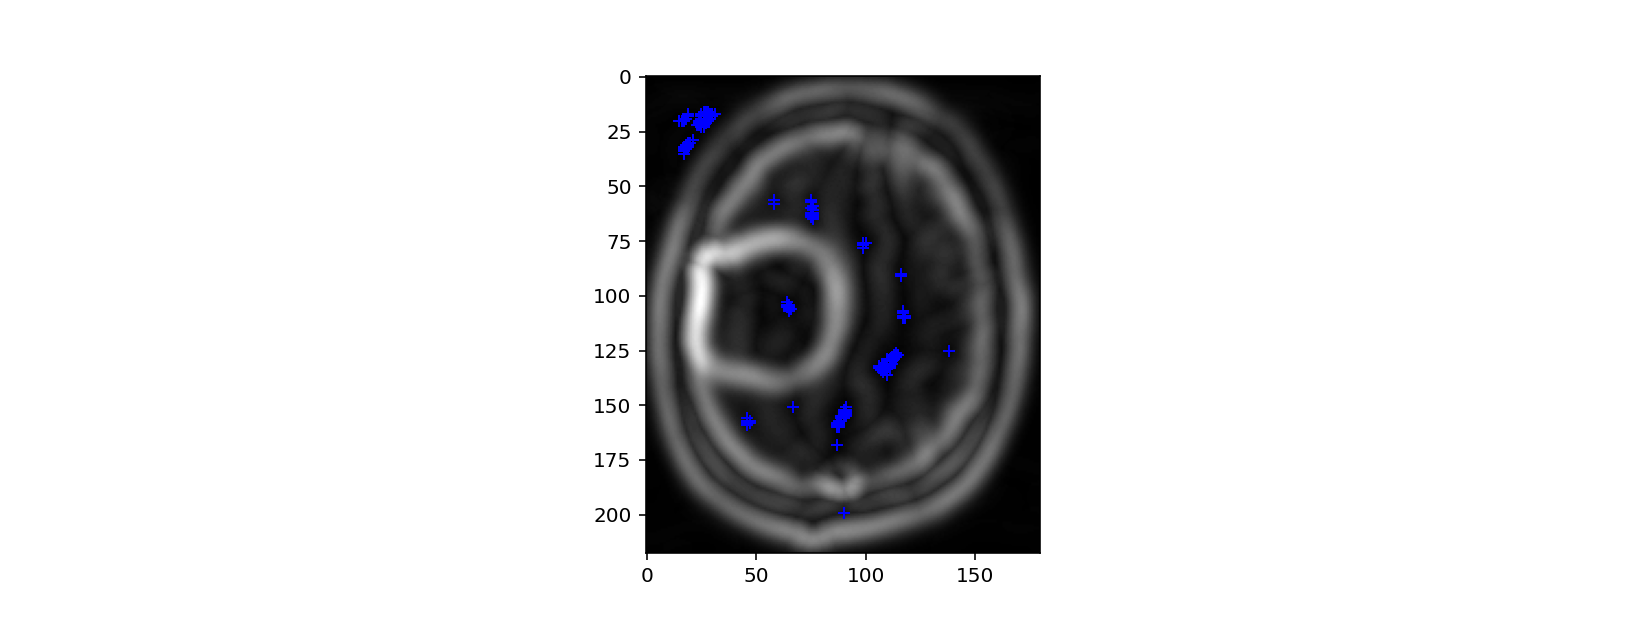

In [153]:
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage.feature import peak_local_max

def get_markers(im, indices=False):
    im_ = gaussian(im, sigma=4)
    gradr = rank.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = rank.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = rank.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb
    
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=15,indices=indices),grad

markers,grad = get_markers(im, True)  
plt.figure()
plt.imshow(grad, cmap=plt.cm.gray)
plt.plot(markers[:,1],markers[:,0],'b+')
plt.show()

We can see those markers in blue on the image above. For each marker we will associate an unique number called label. 
With the label we will be able to dinstinguish each different region separatly. Boundaries betweeen regions will be marked.

<ipython-input-153-05f070360673>:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  im_ = gaussian(im, sigma=4)


<IPython.core.display.Javascript object>


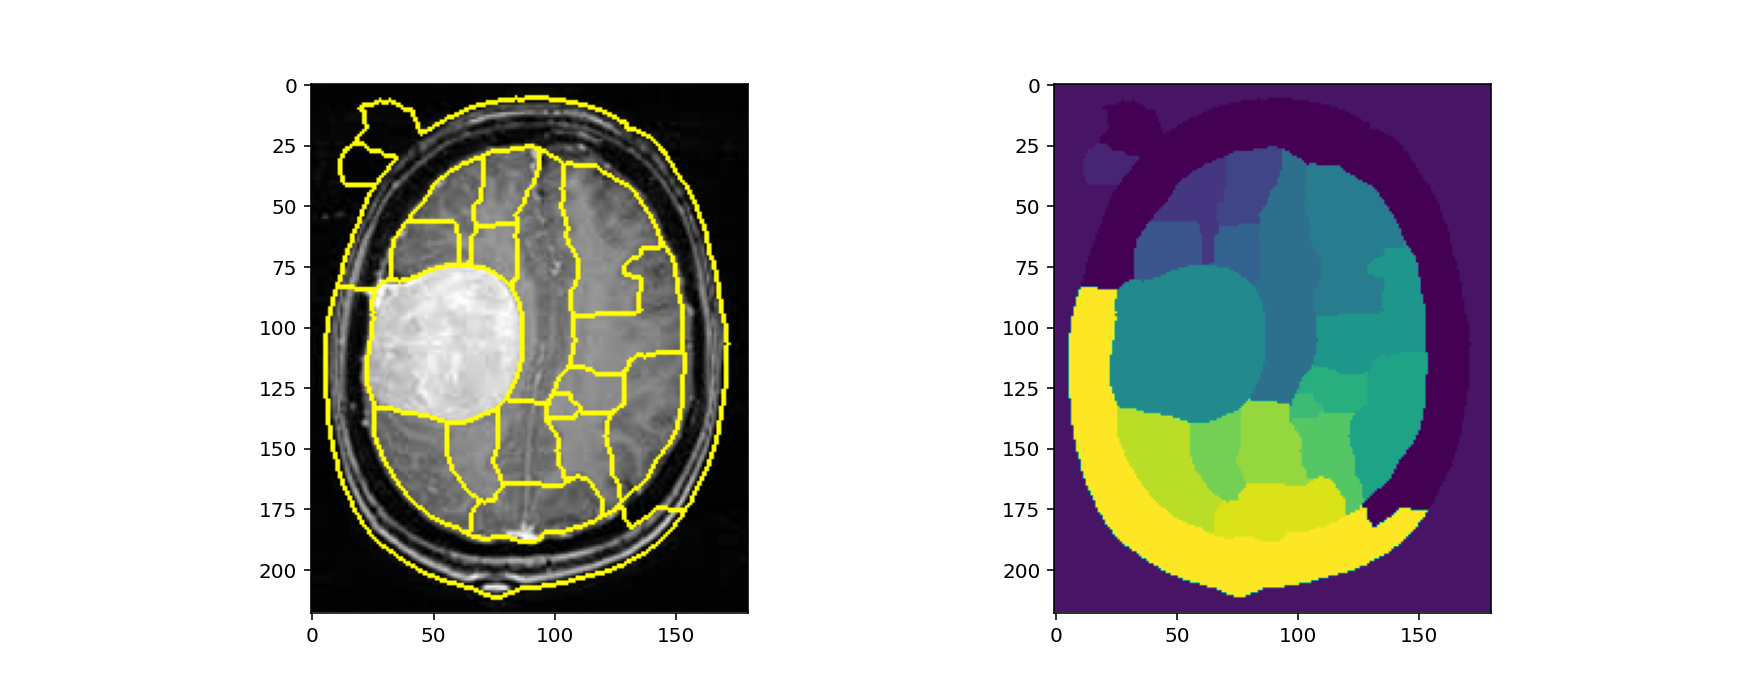

In [156]:
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label

markers, grad = get_markers(im, False)
markers = label(markers)
ws = watershed(grad, markers) 

plt.figure()
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(im,ws))  
plt.subplot(1,2,2)
plt.imshow(ws)
plt.show()

Now for each region we will compute the mean value for the three rgb channels. 

<IPython.core.display.Javascript object>


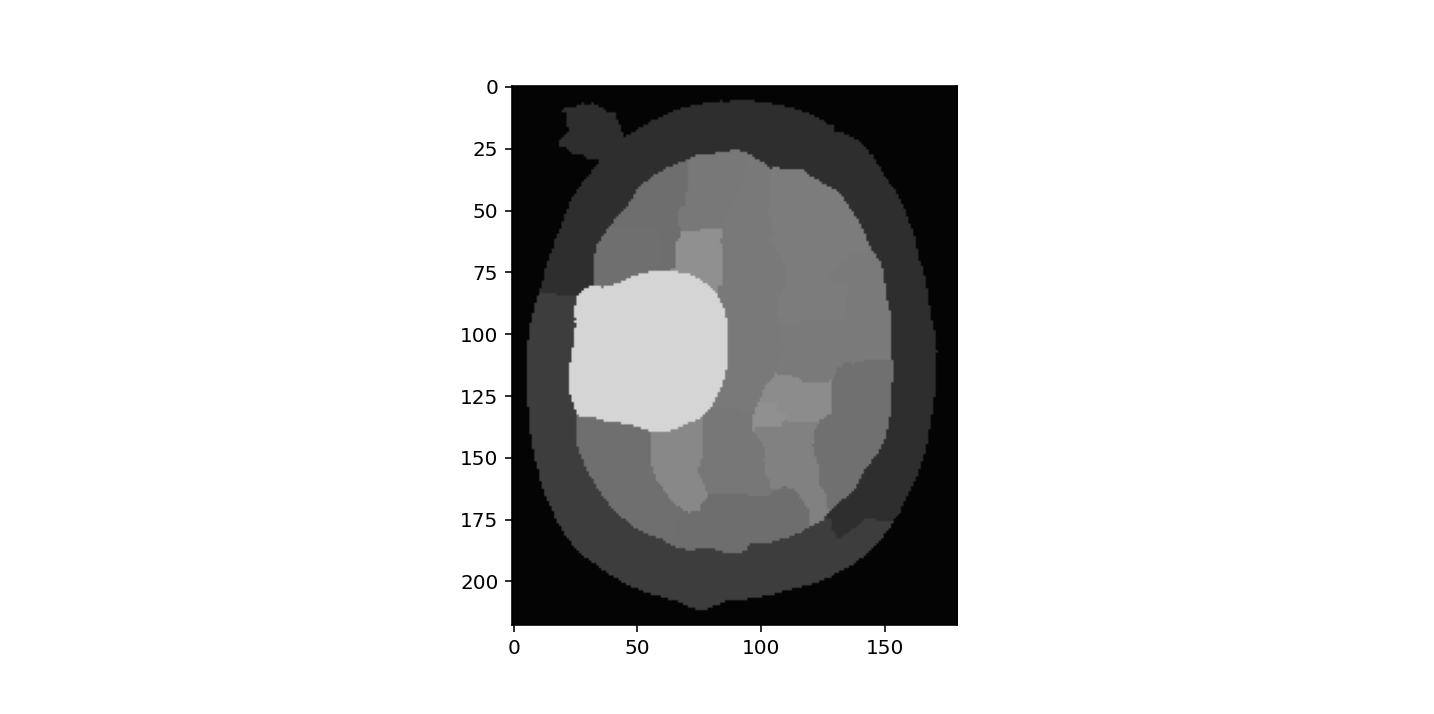

In [157]:
def get_descr(region):
    return [region[:,0].mean(), region[:,1].mean(), region[:,2].mean()]

descriptors = np.zeros((ws.max()+1,3))
im_descriptors = np.zeros_like(im)

for i in range(ws.min(),ws.max()+1):
    descriptors[i] = get_descr(im[ws==i])
    im_descriptors[ws==i] = descriptors[i]
    
plt.figure()
plt.imshow(im_descriptors)
plt.show()

We can now isolate one particular region by first making a mask and then applying it to the initial image. The brightest pixels represent the tumor.

<IPython.core.display.Javascript object>


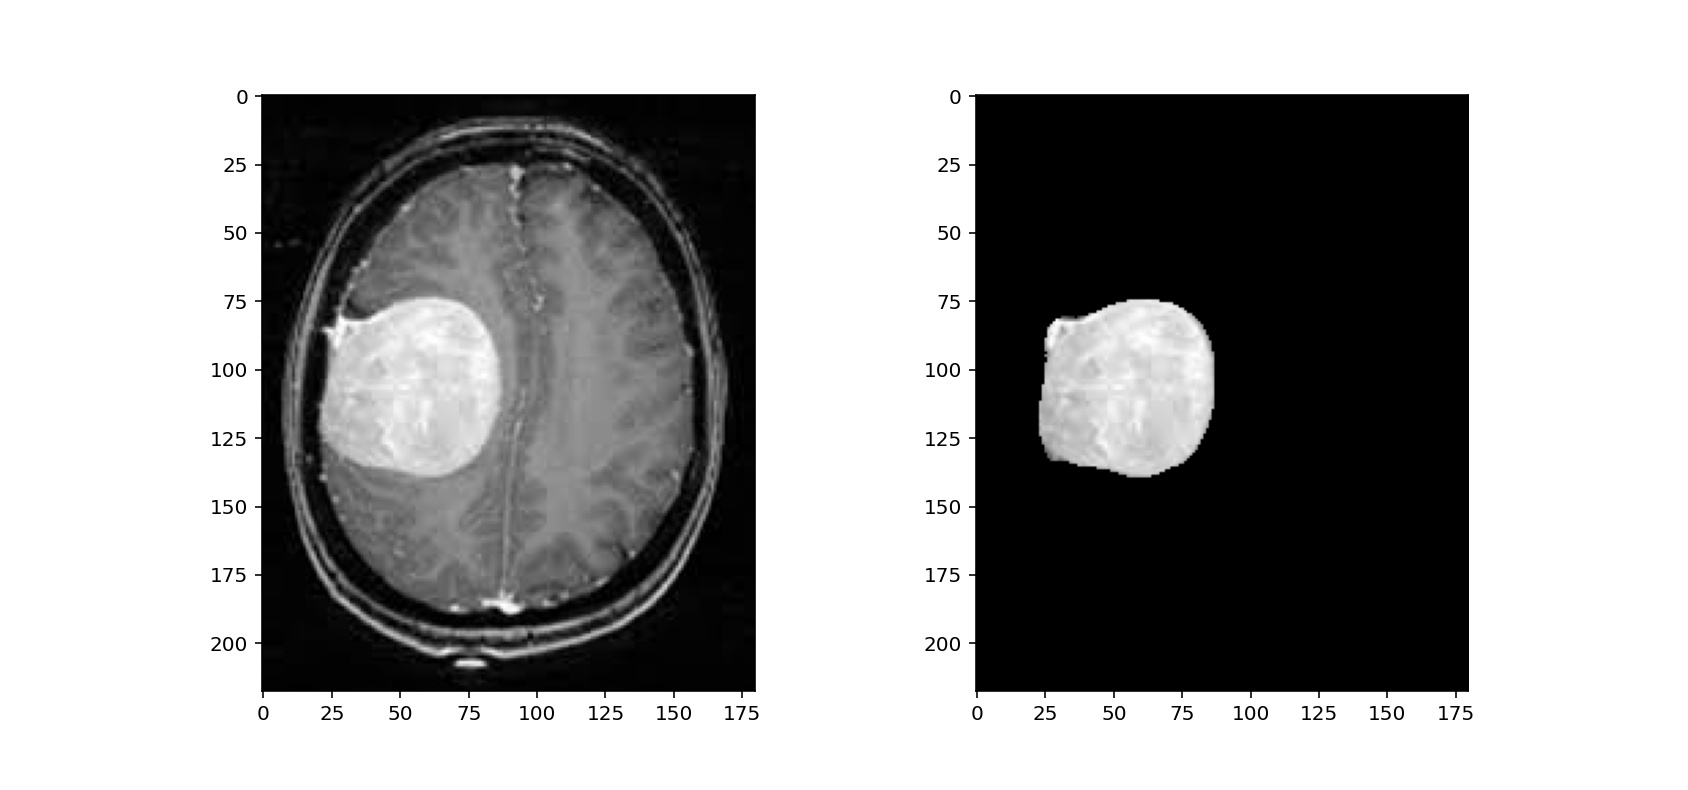

In [158]:
tumor_label=im_descriptors.max()

mask=(im_descriptors!=[tumor_label,tumor_label,tumor_label])
im2=im.copy()
im2[mask]=0


plt.figure()
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

In the last image, we can see that the pixels that represent the tumor are labeled to the same number and have the same value. To calculate the area of the tumor we need to know the number of the bright pixels.

In [161]:
px=0
for j in range(im2.shape[1]):
    for i in range(im2.shape[0]):
        if(im2[i,j,0]>0):
            px+=1
print("number of pixels = ", px)
print ("Tumor area = ",px*0.115*0.115, "cm^2")

number of pixels =  3484
Tumor area =  46.075900000000004 cm^2
